## Setup

All installations and imports

In [ ]:
!pip install seaborn lazypredict lightgbm xgboost

In [ ]:
import os
import glob
import lazypredict
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import uuid
import os.path
from scipy import stats
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyRegressor
from sklearn.linear_model import Ridge, LinearRegression
from xgboost import XGBRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


## Load google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Base path to the dataset directory
base_path = '/content/drive/MyDrive/datasets/Volcano_Dataset/'

print(f'base_path - {base_path}')


base_path - /content/drive/MyDrive/datasets/Volcano_Dataset/


## Load Dataset (Only run this if there is no prior processed data csv available)

Initializing columns for the dataframe

In [ ]:
column_names = ['G', 'rho', 'mu', 'rc', 'M', 'sigma', 'time_to_erupt', 'tilt_erupt', 'erupted']
df = pd.DataFrame(columns=column_names)


Reading Data From Google Drive

In [ ]:
# Listing all volcano directories
volcano_dirs = glob.glob(os.path.join(base_path, 'Volcano*'))

print(f'volcano_dirs - {volcano_dirs}')



volcano_dirs - ['/content/drive/MyDrive/datasets/Volcano_Dataset/Volcano7', '/content/drive/MyDrive/datasets/Volcano_Dataset/Volcano4', '/content/drive/MyDrive/datasets/Volcano_Dataset/Volcano8', '/content/drive/MyDrive/datasets/Volcano_Dataset/Volcano3', '/content/drive/MyDrive/datasets/Volcano_Dataset/Volcano10', '/content/drive/MyDrive/datasets/Volcano_Dataset/Volcano1', '/content/drive/MyDrive/datasets/Volcano_Dataset/Volcano2', '/content/drive/MyDrive/datasets/Volcano_Dataset/Volcano9', '/content/drive/MyDrive/datasets/Volcano_Dataset/Volcano5', '/content/drive/MyDrive/datasets/Volcano_Dataset/Volcano6']


Helper methods to process the volcano readings into a format that we can use as a dataframe

In [ ]:
import math

def is_integer(s):
    return s.isdigit()

def is_float(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

def create_observation_dict(observation_files):
  # Looping through each observation file
  for observation_file in observation_files:
      # Processing each observation file
      with open(observation_file, 'r') as file:
        content = file.read()
        parts = content.split('\n')  # Split based on newline character
        observation = {}
        sensor_time = False
        sensor_data = False

        volcano_number = int(observation_file.split('/')[-2].replace('Volcano', ''))
        observation_number = int(observation_file.split('/')[-1].replace('observation', '').replace('.txt', ''))

        observation['volcano_number'] = volcano_number
        observation['observation_number'] = observation_number

        for part in parts:
          # skip if there is a space
          if part == ' ':
            continue
          # ignore tilt_erupt as specified that the data might be invalid
          if part.startswith('tilt_erupt'):
            sensor_time = True
            continue
          # this flag exists to check if we are processing the time left for eruption
          if sensor_time:
            sensor_time = False
            sensor_data = True
            observation['time']= part
            continue
          # this flag exists to check if we are processing the sensor data
          if sensor_data:
            observation['sensor_data']= part
            break

          # If all is good we spilt based on ,
          kv = part.split(',')

          # We are looking at skipping this data since its constant in all observations
          if str(kv[0]) in ['v', 'Patm', 'g', 'r']:
            continue

          # Split on ^ if there is a float value involved
          if '^' in kv[1]:
            base, exponent = kv[1].split('^')
            observation[str(kv[0])]= round(math.pow(float(base), float(exponent)), 3)
          # Check if value is an integer
          elif is_integer(kv[1]):
            observation[str(kv[0])]= int(kv[1])
          # Check if value is a float
          elif is_float(kv[1]):
            observation[str(kv[0])]= float(kv[1])
          # For the rest of the observations
          else:
            observation[str(kv[0])]= kv[1]

        observations.append(observation)

In [ ]:
def create_dataframe_from_observation(df, column_names, observation):

  times = observation['time'].split(',')
  sensor_data = observation['sensor_data'].split(',')


  start_time = abs(int(times[0]))

  # 47 works to cover all indexes. tried various combinations to get this right
  window_counter = start_time - 47

  for i in range(0, window_counter):
    temp_df = pd.DataFrame([observation])
    temp_df = temp_df.drop(columns=['time', 'sensor_data'])
    time_to_erupt = start_time - i
    temp_df['time_to_erupt'] = time_to_erupt
    s = sensor_data[i:i+50]
    temp_df['tilt_erupt'] = s[-1]
    if s[-1] == sensor_data[-1]:
      print("Erupted")
      temp_df['erupted'] = 1
    else:
      temp_df['erupted'] = 0
    s_floats = [float(value) for value in s]
    sensor_column_names = [f's{i}' for i in range(len(s_floats))]
    sens_df = pd.DataFrame([s_floats], columns=sensor_column_names)
    temp_df = pd.concat([temp_df, sens_df], axis=1)
    df = pd.concat([df, temp_df], axis=0, ignore_index=True)

  return df

Code to process each data file to generate the dataframe which will be the base on which we will work on.

In [ ]:
# Looping through each volcano directory
for volcano_dir in volcano_dirs:
    observations = []
    # Listing all observation files in the current volcano directory
    observation_files = glob.glob(os.path.join(volcano_dir, 'observation*.txt'))

    print(f'observation_files - {observation_files}')

    # creating an observation dictionary to further processs the data
    create_observation_dict(observation_files)

    print(f'observations created processing files')
    for observation in observations:
      print(f'processing observation {observation["observation_number"]}')
      df = create_dataframe_from_observation(df, column_names, observation)


In [ ]:
df.head()

In [ ]:
df.to_csv('/content/drive/MyDrive/datasets/Volcano_Dataset/processed_volcanic_sensor_dataset.csv', index=False)

Decided to save the dataframe to a csv so that I could load it easily for further processing. It took about 2 hours to prepare the dataframe so this should save time.

## Load processed dataset

Read pre-saved dataset into dataframe

In [ ]:
df = pd.read_csv(base_path + 'processed_volcanic_sensor_dataset.csv')

In [ ]:
df.shape

(268358, 61)

In [ ]:
df.head()

,G,rho,mu,rc,M,sigma,time_to_erupt,tilt_erupt,erupted,volcano_number,...,s40,s41,s42,s43,s44,s45,s46,s47,s48,s49
0,186208713666.29,2300,16595.87,26,676082.97,0.10,1361,-0.00,0,7.00,...,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00
1,186208713666.29,2300,16595.87,26,676082.97,0.10,1360,-0.00,0,7.00,...,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,-0.00
2,186208713666.29,2300,16595.87,26,676082.97,0.10,1359,-0.00,0,7.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00
3,186208713666.29,2300,16595.87,26,676082.97,0.10,1358,-0.00,0,7.00,...,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00
4,186208713666.29,2300,16595.87,26,676082.97,0.10,1357,-0.00,0,7.00,...,0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00


## Data Cleaning

After processing the sensor data there seems to be 6 NaN values for s49 column. I filled it with s48 since we can say the reading was tilt erupt so there would be no change in it.

In [ ]:
null_sum = df.isnull().sum()
null_columns = null_sum[null_sum > 0]
print(null_columns)

s49    6
dtype: int64


In [ ]:
df['s49'] = df['s49'].fillna(df['s48'])

In [ ]:
df[df.isnull().any(axis=1)]

,G,rho,mu,rc,M,sigma,time_to_erupt,tilt_erupt,erupted,volcano_number,...,s40,s41,s42,s43,s44,s45,s46,s47,s48,s49


## Exploratory Data Analysis and Feature Engineering

Tilt readings are sensor data thats got from a tiltmeter which measures the angle at the flank of a volcano. Here is a good understanding of it.
[Volcanic monitoring methods](https://hilo.hawaii.edu/~kenhon/GEOL205/monitor/monitors.html)

As the magma from the volcano builds up just below the flank the tilt angle rises and just before eruption there is a sharp drop in the tiltmeter. Rapid summit deflation is often a precursor to a flank eruption and, therefore, a useful monitoring tool.

So here we will generate the rate of change between consecutive sensor readings to capture this effect.

In [ ]:
sensor_column_names = [f's{i}' for i in range(50)]
sensor_data_df = df[sensor_column_names]

for i in range(50):
    sensor_column = f's{i}'
    rate_column = f'r{i}'
    sensor_data_df[rate_column] = sensor_data_df[sensor_column].diff()

sensor_data_df.drop(sensor_column_names, axis=1, inplace=True)

sensor_data_df.loc[0, [f'r{i}' for i in range(50)]] = 0
sensor_data_df.head()


,r0,r1,r2,r3,r4,r5,r6,r7,r8,r9,...,r40,r41,r42,r43,r44,r45,r46,r47,r48,r49
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,...,-0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00
2,-0.00,0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,0.00,...,0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00
3,0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,...,-0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00
4,-0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,...,-0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00


In [ ]:
df = pd.concat([df, sensor_data_df], axis=1)
df.head()

,G,rho,mu,rc,M,sigma,time_to_erupt,tilt_erupt,erupted,volcano_number,...,r40,r41,r42,r43,r44,r45,r46,r47,r48,r49
0,186208713666.29,2300,16595.87,26,676082.97,0.10,1361,-0.00,0,7.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,186208713666.29,2300,16595.87,26,676082.97,0.10,1360,-0.00,0,7.00,...,-0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00
2,186208713666.29,2300,16595.87,26,676082.97,0.10,1359,-0.00,0,7.00,...,0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00
3,186208713666.29,2300,16595.87,26,676082.97,0.10,1358,-0.00,0,7.00,...,-0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00
4,186208713666.29,2300,16595.87,26,676082.97,0.10,1357,-0.00,0,7.00,...,-0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00


Ploting a line graph for sensor reading just before eruption and otherwise when there is no eruption

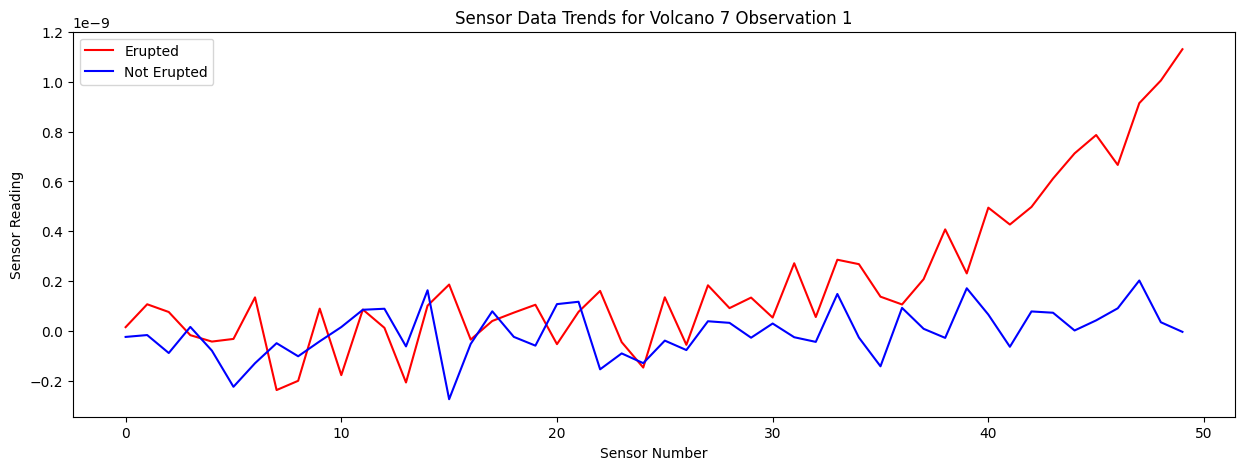

In [ ]:
# Filter the DataFrame for the same volcano and observation number
volcano_number = 7
observation_number = 1

# Get one row that erupted and one that did not for the same volcano and observation
erupted_row = df[(df['volcano_number'] == volcano_number) &
                 (df['observation_number'] == observation_number) &
                 (df['erupted'] == 1)]

not_erupted_row = df[(df['volcano_number'] == volcano_number) &
                     (df['observation_number'] == observation_number) &
                     (df['erupted'] == 0)]

# Plot the sensor data for the erupted row
plt.figure(figsize=(15, 5))
plt.plot(erupted_row.iloc[0][['s' + str(i) for i in range(50)]].values, label='Erupted', color='red')

# Plot the sensor data for the not erupted row
plt.plot(not_erupted_row.iloc[0][['s' + str(i) for i in range(50)]].values, label='Not Erupted', color='blue')

plt.title('Sensor Data Trends for Volcano {} Observation {}'.format(volcano_number, observation_number))
plt.xlabel('Sensor Number')
plt.ylabel('Sensor Reading')
plt.legend()
plt.show()

We can see here that for volcano 7 and observation 1 just before eruption the sensor reading spikes

Lets plot the rate of change just before eruption vs otherwise for the same volcano and observation

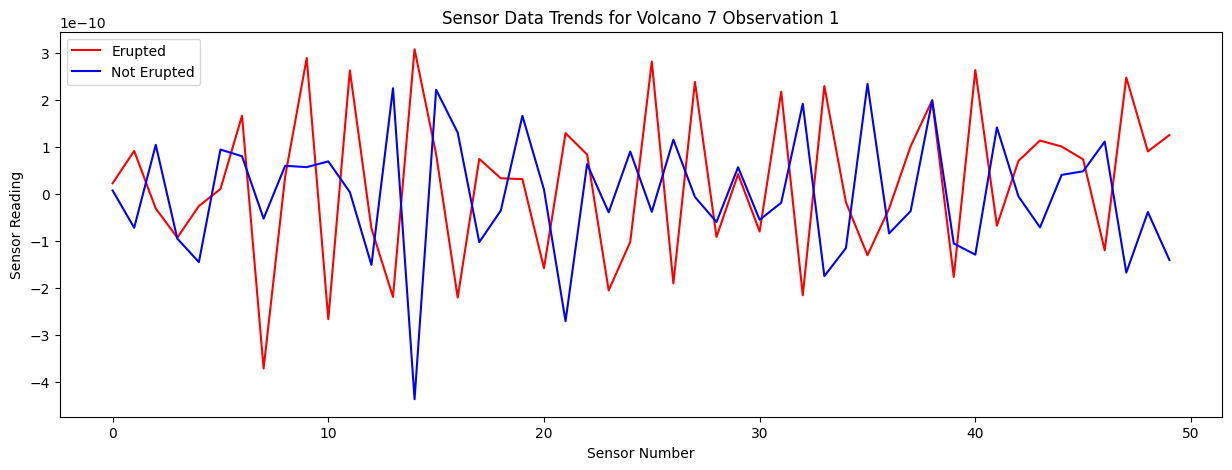

In [ ]:
# Filter the DataFrame for the same volcano and observation number
volcano_number = 7
observation_number = 1

# Get one row that erupted and one that did not for the same volcano and observation
erupted_row = df[(df['volcano_number'] == volcano_number) &
                 (df['observation_number'] == observation_number) &
                 (df['erupted'] == 1)]

not_erupted_row = df[(df['volcano_number'] == volcano_number) &
                     (df['observation_number'] == observation_number) &
                     (df['erupted'] == 0)]

# Plot the sensor data for the erupted row
plt.figure(figsize=(15, 5))
plt.plot(erupted_row.iloc[0][['r' + str(i) for i in range(50)]].values, label='Erupted', color='red')

# Plot the sensor data for the not erupted row
plt.plot(not_erupted_row.iloc[1][['r' + str(i) for i in range(50)]].values, label='Not Erupted', color='blue')

plt.title('Sensor Data Trends for Volcano {} Observation {}'.format(volcano_number, observation_number))
plt.xlabel('Sensor Number')
plt.ylabel('Sensor Reading')
plt.legend()
plt.show()

There oscillation in the rate of change just before eruption seems more in magnitude than otherwise.

To get a better understanding of the sensor data and the rate of change(roc) of the sensor data. We are going to compute the mean and std. deviation of the sensor data and the standard deviation of the roc of the sensor. We will then compare the these values between erupted and not erupted rows.

In [ ]:
sensor_columns = ['s' + str(i) for i in range(50)]
sensor_roc_columns = ['r' + str(i) for i in range(50)]
sensor_data_df = df[sensor_columns]
sensor_roc_df = df[sensor_roc_columns]

# Calculate the standard deviation for each row
df['std_deviation'] = sensor_data_df.std(axis=1)

# Calculate the standard deviation for each row
df['sensor_value_mean'] = sensor_data_df.mean(axis=1)

# Calculate the standard deviation roc for each row
df['std_deviation_roc'] = sensor_roc_df.std(axis=1)


df.head()



,G,rho,mu,rc,M,sigma,time_to_erupt,tilt_erupt,erupted,volcano_number,...,r43,r44,r45,r46,r47,r48,r49,std_deviation,sensor_value_mean,std_deviation_roc
0,186208713666.29,2300,16595.87,26,676082.97,0.10,1361,-0.00,0,7.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00
1,186208713666.29,2300,16595.87,26,676082.97,0.10,1360,-0.00,0,7.00,...,-0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.00
2,186208713666.29,2300,16595.87,26,676082.97,0.10,1359,-0.00,0,7.00,...,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00
3,186208713666.29,2300,16595.87,26,676082.97,0.10,1358,-0.00,0,7.00,...,0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00
4,186208713666.29,2300,16595.87,26,676082.97,0.10,1357,-0.00,0,7.00,...,0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00,-0.00,0.00


Lets now check the standard deviation of sensor data rate of change between erupted reading and not erupted

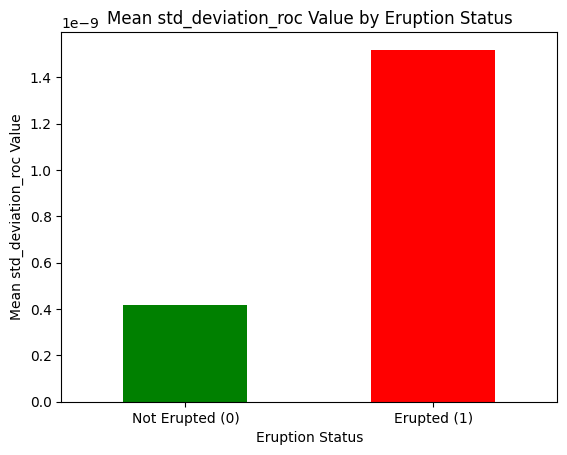

In [ ]:
# Calculate the mean 'std_deviation_roc' value for each 'erupted' category
mean_std_deviation_roc_per_eruption_status = df.groupby('erupted')['std_deviation_roc'].mean()

# Plot the mean 'std_deviation_roc' values for each eruption status as a bar plot
mean_std_deviation_roc_per_eruption_status.plot(kind='bar', color=['green', 'red'])

plt.title('Mean std_deviation_roc Value by Eruption Status')
plt.xlabel('Eruption Status')
plt.ylabel('Mean std_deviation_roc Value')
plt.xticks(ticks=[0, 1], labels=['Not Erupted (0)', 'Erupted (1)'], rotation=0)  # Set custom labels for the x-axis ticks
plt.show()

We can clearly see that the erupted volcano sensor readings have a higher std. deviation than the not erupted one

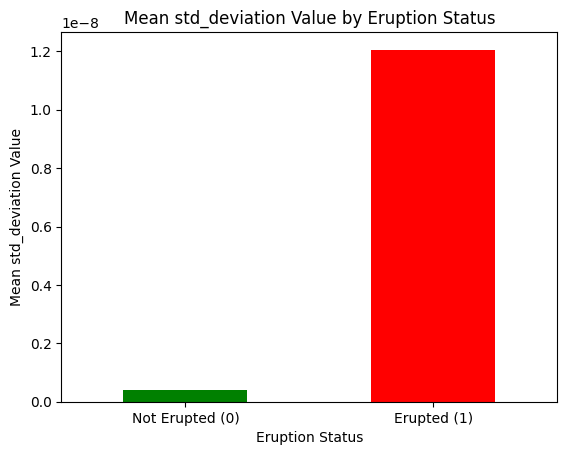

In [ ]:
# Calculate the mean 'std_deviation_roc' value for each 'erupted' category
mean_std_deviation_per_eruption_status = df.groupby('erupted')['std_deviation'].mean()

# Plot the mean 'std_deviation_roc' values for each eruption status as a bar plot
mean_std_deviation_per_eruption_status.plot(kind='bar', color=['green', 'red'])

plt.title('Mean std_deviation Value by Eruption Status')
plt.xlabel('Eruption Status')
plt.ylabel('Mean std_deviation Value')
plt.xticks(ticks=[0, 1], labels=['Not Erupted (0)', 'Erupted (1)'], rotation=0)  # Set custom labels for the x-axis ticks
plt.show()

We can clearly see that the erupted volcano sensor readings rate of change have a higher std. deviation than the not erupted one

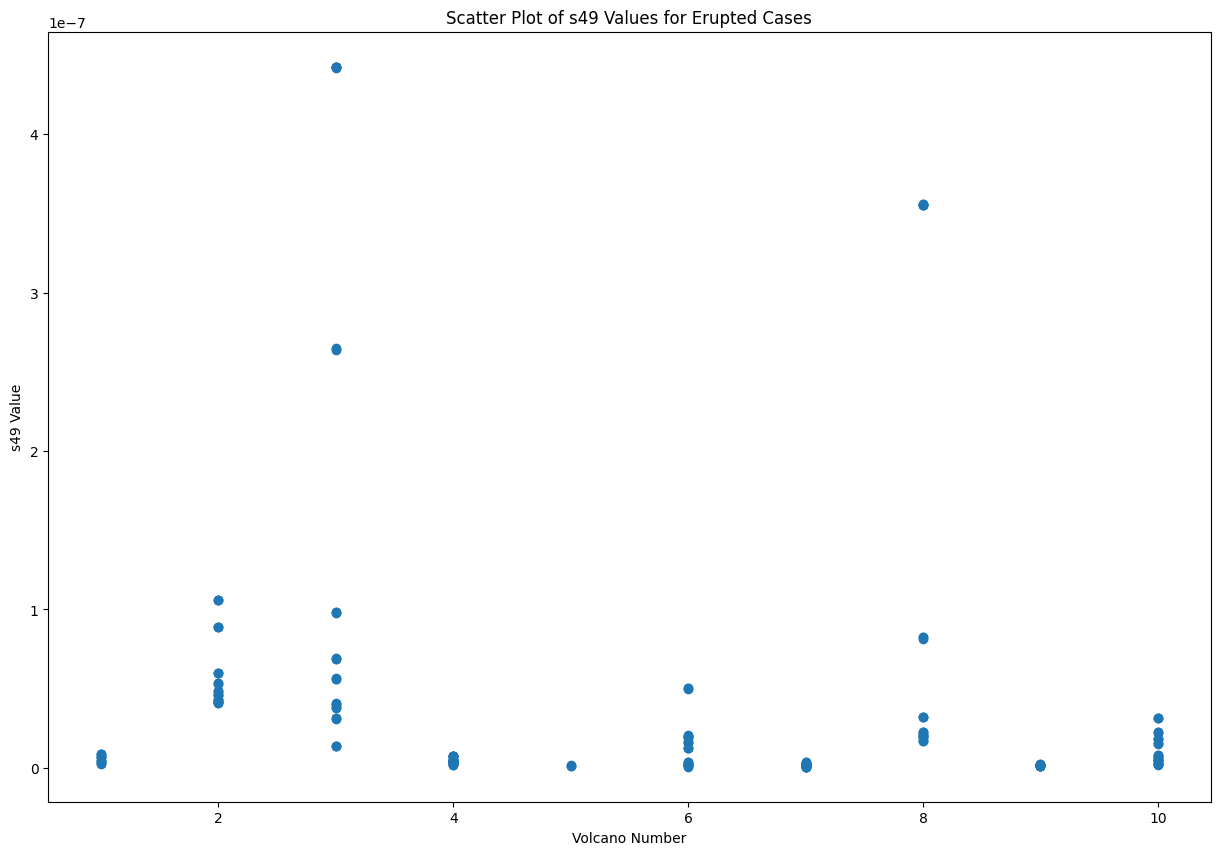

In [ ]:
# Filter the DataFrame to include only rows where 'erupted' is 1
erupted_df = df[df['erupted'] == 1]

# Create a scatter plot
plt.figure(figsize=(15, 10))
plt.scatter(erupted_df['volcano_number'], erupted_df['s49'])

# Set the title and labels
plt.title('Scatter Plot of s49 Values for Erupted Cases')
plt.xlabel('Volcano Number')
plt.ylabel('s49 Value')

# Show the plot
plt.show()

In [ ]:
erupted_df['s49'].describe()

count   224.00
mean      0.00
std       0.00
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.00
Name: s49, dtype: float64

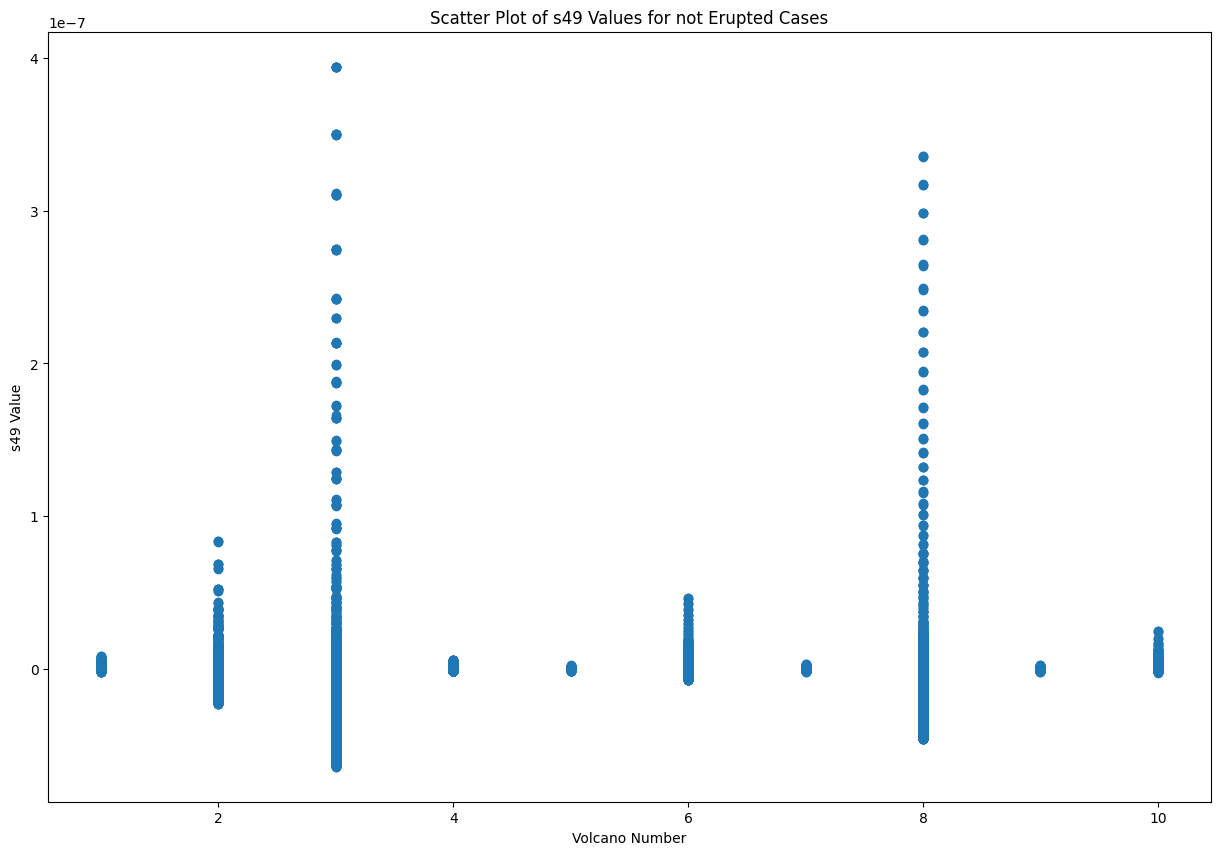

In [ ]:
# Filter the DataFrame to include only rows where 'erupted' is 0
not_erupted_df = df[df['erupted'] == 0]

# Create a scatter plot
plt.figure(figsize=(15, 10))
plt.scatter(not_erupted_df['volcano_number'], not_erupted_df['s49'])

# Set the title and labels
plt.title('Scatter Plot of s49 Values for not Erupted Cases')
plt.xlabel('Volcano Number')
plt.ylabel('s49 Value')

# Show the plot
plt.show()

In [ ]:
not_erupted_df['s49'].describe()

count   268134.00
mean        -0.00
std          0.00
min         -0.00
25%         -0.00
50%         -0.00
75%          0.00
max          0.00
Name: s49, dtype: float64

After analysing scater plots of s['49'] values for erupted and not erupted cases there doesn't seem to be any useful information from the single value plot

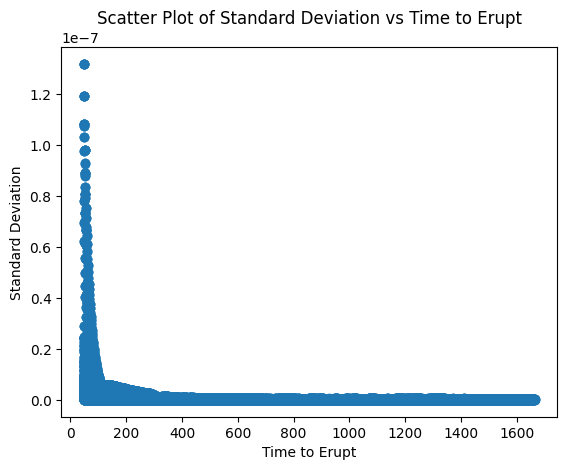

In [ ]:
# Create a scatter plot of std_deviation vs time_to_erupt
plt.scatter(df['time_to_erupt'], df['std_deviation'])

# Set the title and labels
plt.title('Scatter Plot of Standard Deviation vs Time to Erupt')
plt.xlabel('Time to Erupt')
plt.ylabel('Standard Deviation')

# Show the plot
plt.show()

There is a non-linear relationship between standard deviation of sensor readings and time to erupt.

In [ ]:
df['time_to_erupt'].describe()

count   268358.00
mean       672.60
std        371.45
min         48.00
25%        355.00
50%        663.00
75%        971.00
max       1665.00
Name: time_to_erupt, dtype: float64

## Normalisation

Box cox transformation (helps with prediction since the sensor related readings are too small)

In [ ]:
# Transform sensor data
for i in range(50):
    sensor_column = f's{i}'
    sensor_roc_column = f'r{i}'
    df[sensor_column], fitted_lambda_sensor = boxcox(df[sensor_column] + 1)  # Adding 1 to shift data to positive if necessary
    df[sensor_roc_column], fitted_lambda_sensor_roc = boxcox(df[sensor_column] + 1)  # Adding 1 to shift data to positive if necessary

# Transform tilt_erupt
df['tilt_erupt'], fitted_lambda_tilt_erupt = boxcox(df['tilt_erupt'] + 1)  # Adding 1 to shift data to positive if necessary
df['std_deviation'], fitted_lambda_std_deviation = boxcox(df['std_deviation'] + 1)  # Adding 1 to shift data to positive if necessary
df['sensor_value_mean'], fitted_lambda_sensor_value_mean = boxcox(df['sensor_value_mean'] + 1)  # Adding 1 to shift data to positive if necessary
df['std_deviation_roc'], fitted_lambda_std_deviation_roc = boxcox(df['std_deviation_roc'] + 1)  # Adding 1 to shift data to positive if necessary

We will use the MinMaxScaler for time_to_erupt column and box cox for all sensor and sensor derived columns.
The columns ['G',	'rho',	'mu',	'rc',	'M',	'sigma'] don't add useful information to the eruption of the volcano under all cases the volcano erupted

In [ ]:
X_copy = df['time_to_erupt']

scaler = MinMaxScaler()

X_copy = X_copy.values.reshape(-1, 1)

X_scaled = scaler.fit_transform(X_copy)

X_scaled = pd.DataFrame(X_scaled, columns=['time_to_erupt'])

X = df.drop(['G',	'rho',	'mu',	'rc',	'M',	'sigma', 'time_to_erupt'], axis=1)

X_scaled_modified = pd.concat([X, X_scaled], axis=1)

In [ ]:
X_scaled_modified.head()

,tilt_erupt,erupted,volcano_number,observation_number,s0,s1,s2,s3,s4,s5,...,r44,r45,r46,r47,r48,r49,std_deviation,sensor_value_mean,std_deviation_roc,time_to_erupt
0,-0.00,0,7.00,1.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,...,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,0.81
1,-0.00,0,7.00,1.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,...,0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,0.00,0.81
2,-0.00,0,7.00,1.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,...,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.00,0.81
3,-0.00,0,7.00,1.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,...,0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.00,0.81
4,-0.00,0,7.00,1.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,...,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.00,0.81


## Split data for training, validation and testing

We need to split the train, validation and test per the volcano number and observation number.

In [ ]:
# Group the data by 'volcano_number'
grouped = X_scaled_modified.groupby(['volcano_number'])

# Create a list of unique groups (each group is a DataFrame)
groups = [grouped.get_group(x) for x in grouped.groups]

# Split the groups into training, validation, and test sets
train_groups, test_groups = train_test_split(groups, test_size=0.2, random_state=42)
validation_groups, test_groups = train_test_split(test_groups, test_size=0.5, random_state=42)

# Concatenate the groups within each set to form the final datasets
train_df = pd.concat(train_groups).reset_index(drop=True)
validation_df = pd.concat(validation_groups).reset_index(drop=True)
test_df = pd.concat(test_groups).reset_index(drop=True)

Let's make sure the dataframes are unique and are not able to see any overlap of the same observations.

In [ ]:
train_combinations = set(train_df['volcano_number'])
validation_combinations = set(validation_df['volcano_number'])
test_combinations = set(test_df['volcano_number'])

print(f"train_combinations : {train_combinations}")
print(f"validation_combinations : {validation_combinations}")
print(f"train_combinations : {test_combinations}")

common_train_validation = train_combinations.intersection(validation_combinations)
print(f"training and validation datasets intersection: {common_train_validation}")

common_train_test = train_combinations.intersection(test_combinations)
print(f"training and test datasets intersection: {common_train_test}")

common_validation_test = validation_combinations.intersection(test_combinations)
print(f"validation and test datasets intersection: {common_validation_test}")

train_combinations : {1.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 10.0}
validation_combinations : {9.0}
train_combinations : {2.0}
training and validation datasets intersection: set()
training and test datasets intersection: set()
validation and test datasets intersection: set()


Let's split the train dataset on training features and target both for tilt erupt value prediction and time of eruption prediction

In [ ]:
train_df_value_Y = train_df['tilt_erupt']
train_df_value_X = train_df.drop(['tilt_erupt'], axis=1)

train_df_time_Y = train_df['time_to_erupt']
train_df_time_X = train_df.drop(['time_to_erupt'], axis=1)


validation_df_value_Y = validation_df['tilt_erupt']
validation_df_value_X = validation_df.drop(['tilt_erupt'], axis=1)

validation_df_time_Y = validation_df['time_to_erupt']
validation_df_time_X = validation_df.drop(['time_to_erupt'], axis=1)


test_df_value_Y = test_df['tilt_erupt']
test_df_value_X = test_df.drop(['tilt_erupt'], axis=1)

test_df_time_Y = test_df['time_to_erupt']
test_df_time_X = test_df.drop(['time_to_erupt'], axis=1)



## Model selection, training, evalaution and prediction

For prediction of both tilt eruption value and time to erupt we would need to use Regression models since we need a value. We will run lazypredict to train and evaluate the dataset.

### Tilt erupt Prediction

In [ ]:
# Remove High Memory regressor's since its crashing the execution
highmem_regressors = [
    "GammaRegressor", "GaussianProcessRegressor", "KernelRidge", "QuantileRegressor", "NuSVR"
]
regressors = [reg for reg in lazypredict.Supervised.REGRESSORS if reg[0] not in highmem_regressors]


reg = LazyRegressor(regressors=regressors, verbose=1, ignore_warnings=True, custom_metric=None)
models, predictions = reg.fit(train_df_value_X, validation_df_value_X, train_df_value_Y, validation_df_value_Y)


print(models)

'tuple' object has no attribute '__name__'
Invalid Regressor(s)


  3%|▎         | 1/37 [04:29<2:41:25, 269.05s/it]

{'Model': 'AdaBoostRegressor', 'R-Squared': -2.0049499093787055, 'Adjusted R-Squared': -2.0253295531832007, 'RMSE': 6.254287657562231e-10, 'Time taken': 269.0453233718872}


  5%|▌         | 2/37 [04:30<1:05:09, 111.70s/it]

{'Model': 'BaggingRegressor', 'R-Squared': -2.004818118823134, 'Adjusted R-Squared': -2.0251968688208573, 'RMSE': 6.254150506343796e-10, 'Time taken': 1.55525541305542}


  8%|▊         | 3/37 [04:33<35:15, 62.22s/it]   

{'Model': 'BayesianRidge', 'R-Squared': 0.9999999999921522, 'Adjusted R-Squared': 0.999999999992099, 'RMSE': 1.0107288535563833e-15, 'Time taken': 3.3325610160827637}


 11%|█         | 4/37 [04:34<20:55, 38.05s/it]

{'Model': 'DecisionTreeRegressor', 'R-Squared': -2.039817962260209, 'Adjusted R-Squared': -2.0604340820524283, 'RMSE': 6.290468937324844e-10, 'Time taken': 0.9868550300598145}


 14%|█▎        | 5/37 [04:35<13:08, 24.66s/it]

{'Model': 'DummyRegressor', 'R-Squared': -2.039817962260283, 'Adjusted R-Squared': -2.0604340820525024, 'RMSE': 6.290468937324921e-10, 'Time taken': 0.9102523326873779}


 16%|█▌        | 6/37 [04:37<08:37, 16.68s/it]

{'Model': 'ElasticNet', 'R-Squared': -2.039817962260283, 'Adjusted R-Squared': -2.0604340820525024, 'RMSE': 6.290468937324921e-10, 'Time taken': 1.1927297115325928}


 19%|█▉        | 7/37 [04:56<08:47, 17.60s/it]

{'Model': 'ElasticNetCV', 'R-Squared': 0.9968296983543106, 'Adjusted R-Squared': 0.9968081972909849, 'RMSE': 2.0314658534032453e-11, 'Time taken': 19.486486196517944}


 22%|██▏       | 8/37 [04:57<05:56, 12.31s/it]

{'Model': 'ExtraTreeRegressor', 'R-Squared': -2.039817962260209, 'Adjusted R-Squared': -2.0604340820524283, 'RMSE': 6.290468937324844e-10, 'Time taken': 0.9803054332733154}


 24%|██▍       | 9/37 [04:58<04:07,  8.83s/it]

{'Model': 'ExtraTreesRegressor', 'R-Squared': -2.0398179622602157, 'Adjusted R-Squared': -2.060434082052435, 'RMSE': 6.290468937324851e-10, 'Time taken': 1.1837255954742432}


 27%|██▋       | 10/37 [05:00<02:57,  6.58s/it]

{'Model': 'GradientBoostingRegressor', 'R-Squared': -2.0398179622602344, 'Adjusted R-Squared': -2.060434082052454, 'RMSE': 6.29046893732487e-10, 'Time taken': 1.5413930416107178}


 30%|██▉       | 11/37 [05:07<02:56,  6.80s/it]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.5510449795219051, 'Adjusted R-Squared': 0.5480001555888915, 'RMSE': 2.417467531606302e-10, 'Time taken': 7.3031158447265625}


 32%|███▏      | 12/37 [05:36<05:40, 13.63s/it]

{'Model': 'HuberRegressor', 'R-Squared': -12944493.67982148, 'Adjusted R-Squared': -13032283.55943997, 'RMSE': 1.2980809735175537e-06, 'Time taken': 29.240071058273315}


 35%|███▌      | 13/37 [05:46<05:00, 12.51s/it]

{'Model': 'KNeighborsRegressor', 'R-Squared': -0.07905292014305387, 'Adjusted R-Squared': -0.08637108344756728, 'RMSE': 3.747836235862354e-10, 'Time taken': 9.91121220588684}


 38%|███▊      | 14/37 [05:47<03:28,  9.08s/it]

{'Model': 'Lars', 'R-Squared': -2.039817962260283, 'Adjusted R-Squared': -2.0604340820525024, 'RMSE': 6.290468937324921e-10, 'Time taken': 1.1516032218933105}


 41%|████      | 15/37 [05:50<02:35,  7.07s/it]

{'Model': 'LarsCV', 'R-Squared': -2.039817962260283, 'Adjusted R-Squared': -2.0604340820525024, 'RMSE': 6.290468937324921e-10, 'Time taken': 2.414271831512451}


 43%|████▎     | 16/37 [05:51<01:51,  5.29s/it]

{'Model': 'Lasso', 'R-Squared': -2.039817962260283, 'Adjusted R-Squared': -2.0604340820525024, 'RMSE': 6.290468937324921e-10, 'Time taken': 1.1427035331726074}


 46%|████▌     | 17/37 [06:10<03:06,  9.34s/it]

{'Model': 'LassoCV', 'R-Squared': 0.9968296983604522, 'Adjusted R-Squared': 0.9968081972971682, 'RMSE': 2.0314658514355338e-11, 'Time taken': 18.77006769180298}


 49%|████▊     | 18/37 [06:11<02:10,  6.88s/it]

{'Model': 'LassoLars', 'R-Squared': -2.039817962260283, 'Adjusted R-Squared': -2.0604340820525024, 'RMSE': 6.290468937324921e-10, 'Time taken': 1.1279165744781494}


 51%|█████▏    | 19/37 [06:14<01:41,  5.64s/it]

{'Model': 'LassoLarsCV', 'R-Squared': -2.039817962260283, 'Adjusted R-Squared': -2.0604340820525024, 'RMSE': 6.290468937324921e-10, 'Time taken': 2.7610552310943604}


 54%|█████▍    | 20/37 [06:17<01:23,  4.91s/it]

{'Model': 'LassoLarsIC', 'R-Squared': -2.039817962260283, 'Adjusted R-Squared': -2.0604340820525024, 'RMSE': 6.290468937324921e-10, 'Time taken': 3.2027833461761475}


 57%|█████▋    | 21/37 [06:20<01:09,  4.35s/it]

{'Model': 'LinearRegression', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 1.1491215073699638e-23, 'Time taken': 3.0303423404693604}


 59%|█████▉    | 22/37 [09:39<15:39, 62.66s/it]

{'Model': 'LinearSVR', 'R-Squared': 0.999035107246398, 'Adjusted R-Squared': 0.999028563320136, 'RMSE': 1.1207242161321258e-11, 'Time taken': 198.64945888519287}


 62%|██████▏   | 23/37 [11:37<18:33, 79.52s/it]

{'Model': 'MLPRegressor', 'R-Squared': -82682918455919.39, 'Adjusted R-Squared': -83243676031807.3, 'RMSE': 0.003280704636674367, 'Time taken': 118.83344030380249}


 65%|██████▍   | 24/37 [11:39<12:09, 56.08s/it]

{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 1.1910932885379792e-24, 'Time taken': 1.3974332809448242}


 68%|██████▊   | 25/37 [11:44<08:09, 40.82s/it]

{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 1.1910932885379792e-24, 'Time taken': 5.222344875335693}


 70%|███████   | 26/37 [11:46<05:21, 29.19s/it]

{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.005566580671289678, 'Adjusted R-Squared': -0.012386357823589211, 'RMSE': 3.6179674007323623e-10, 'Time taken': 2.034665822982788}


 76%|███████▌  | 28/37 [11:50<02:20, 15.56s/it]

{'Model': 'RANSACRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 1.4363131633947428e-23, 'Time taken': 3.547222852706909}


 78%|███████▊  | 29/37 [11:52<01:31, 11.42s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': -2.033023357960703, 'Adjusted R-Squared': -2.053593396580326, 'RMSE': 6.28343477304782e-10, 'Time taken': 1.7641050815582275}


 81%|████████  | 30/37 [11:53<00:58,  8.32s/it]

{'Model': 'Ridge', 'R-Squared': 0.9999960100215631, 'Adjusted R-Squared': 0.9999959829614318, 'RMSE': 7.206833820893192e-13, 'Time taken': 1.0689990520477295}


 84%|████████▍ | 31/37 [11:57<00:40,  6.83s/it]

{'Model': 'RidgeCV', 'R-Squared': 0.9999998390235841, 'Adjusted R-Squared': 0.9999998379318381, 'RMSE': 1.4475726213403119e-13, 'Time taken': 3.340496301651001}


 86%|████████▋ | 32/37 [12:01<00:30,  6.12s/it]

{'Model': 'SGDRegressor', 'R-Squared': -4.768633769343886e+35, 'Adjusted R-Squared': -4.800974760236945e+35, 'RMSE': 249147319.2382399, 'Time taken': 4.470696449279785}


 89%|████████▉ | 33/37 [12:02<00:18,  4.65s/it]

{'Model': 'SVR', 'R-Squared': -2187.947435109344, 'Adjusted R-Squared': -2202.7929301690324, 'RMSE': 1.6880173261070525e-08, 'Time taken': 1.232569932937622}


 92%|█████████▏| 34/37 [12:05<00:12,  4.17s/it]

{'Model': 'TransformedTargetRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 1.1491215073699638e-23, 'Time taken': 3.0456361770629883}


 95%|█████████▍| 35/37 [12:06<00:06,  3.22s/it]

{'Model': 'TweedieRegressor', 'R-Squared': -2.0398179622602792, 'Adjusted R-Squared': -2.060434082052499, 'RMSE': 6.290468937324917e-10, 'Time taken': 0.996218204498291}


 97%|█████████▋| 36/37 [12:10<00:03,  3.22s/it]

{'Model': 'XGBRegressor', 'R-Squared': -2.0398180203274423, 'Adjusted R-Squared': -2.060434140513475, 'RMSE': 6.290468997405766e-10, 'Time taken': 3.22548770904541}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.099063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26563
[LightGBM] [Info] Number of data points in the train set: 218635, number of used features: 107
[LightGBM] [Info] Start training from score -0.000000


100%|██████████| 37/37 [12:15<00:00, 19.87s/it]

{'Model': 'LGBMRegressor', 'R-Squared': 0.9949912104589407, 'Adjusted R-Squared': 0.9949572407257282, 'RMSE': 2.553439813275858e-11, 'Time taken': 5.108250141143799}
                                                    Adjusted R-Squared  \
Model                                                                    
TransformedTargetRegressor                                        1.00   
RANSACRegressor                                                   1.00   
OrthogonalMatchingPursuitCV                                       1.00   
OrthogonalMatchingPursuit                                         1.00   
LinearRegression                                                  1.00   
BayesianRidge                                                     1.00   
RidgeCV                                                           1.00   
Ridge                                                             1.00   
LinearSVR                                                         1.00   
LassoCV             

From the run above there are a few models that we could use ahead to test. We will go with Linear Regression because this is the most simplest algorithm that has excellent R-squared and RMSE and also takes just 4 secs to train.

We need to test this against the test dataset to make sure there is no overfitting.

Going to use the Linear regression algorithm to get the predictions to analyse further so that we can understand the results.

LinearRegression (Validation)

Mean Squared Error: 2.3209677342842963e-25


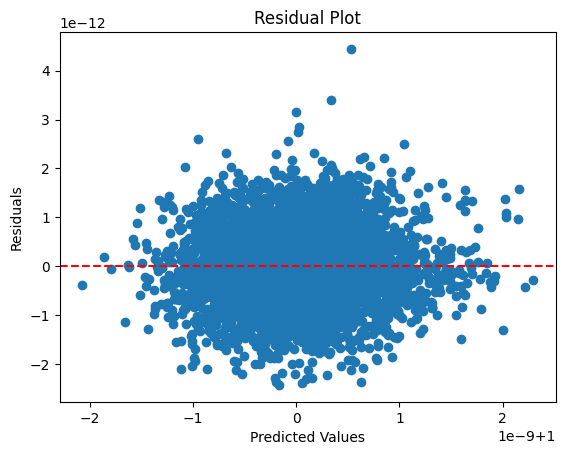

In [ ]:
model = LinearRegression()
model.fit(train_df_value_X, train_df_value_Y)

y_test_pred = model.predict(validation_df_value_X)


original_y_test_pred = inv_boxcox(y_test_pred, fitted_lambda_tilt_erupt)
original_df_value_Y = inv_boxcox(validation_df_value_Y, fitted_lambda_tilt_erupt)

# Evaluate the model's performance
mse = mean_squared_error(original_df_value_Y, original_y_test_pred)

print(f"Mean Squared Error: {mse}")


residuals = original_y_test_pred - original_df_value_Y
plt.scatter(original_y_test_pred, residuals)

plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

plt.axhline(y=0, color='r', linestyle='--')

plt.show()


LinearRegression (Test)

Mean Squared Error: 1.5301057984208629e-24


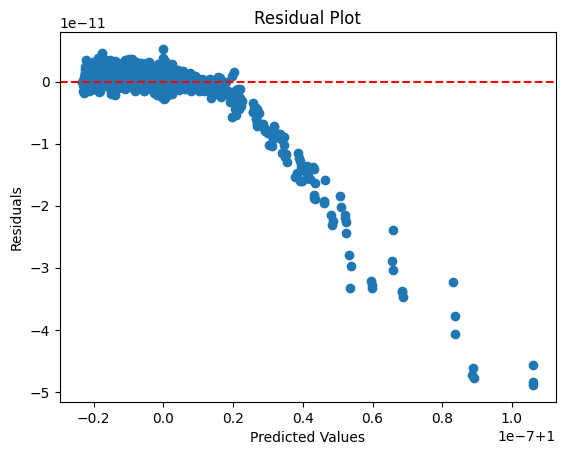

In [ ]:
model = LinearRegression()
model.fit(train_df_value_X, train_df_value_Y)

y_test_pred = model.predict(test_df_value_X)


original_y_test_pred = inv_boxcox(y_test_pred, fitted_lambda_tilt_erupt)
original_df_value_Y = inv_boxcox(test_df_value_Y, fitted_lambda_tilt_erupt)

# Evaluate the model's performance
mse = mean_squared_error(original_df_value_Y, original_y_test_pred)

print(f"Mean Squared Error: {mse}")

residuals = original_y_test_pred - original_df_value_Y
plt.scatter(original_y_test_pred, residuals)

plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

plt.axhline(y=0, color='r', linestyle='--')

plt.show()


 Intepreting the residual plot shows that with the linear regression model there is an increase in error for higher predicted values for the test data.

 For the validation dataset there are no identifiable pattterns.

 ----------



We need to use a model that takes care of the curvature we see in the residuals at higher predicted values.

I am going to try:

LGBMRegressor
LGBMRegressor is a type of gradient boosting framework that uses tree-based learning algorithms and is designed for distributed and efficient training.The LGBMRegressor works by building a series of decision trees in a gradient boosting manner. Each tree is trained to predict and correct the errors made by the previous trees, and the final prediction is made by summing the predictions of all the trees. Since we see non-linearity for higher predictions in the residual plot this might be a good option since it has the least RMSE as per lazy predict.

OrthogonalMatchingPursuitCV
Orthogonal Matching Pursuit (OMP) is a model that is based on a greedy algorithm to select variables. It is particularly useful when you have more features than samples. The algorithm selects variables that are most highly correlated with the residual target after accounting for the other variables already in the model

HistGradientBoostingRegressor
It is based on the principle of gradient boosting, a powerful technique that builds models in a stage-wise fashion by fitting subsequent models to the residual errors made by the previous predictors.

LGBMRegressor (validation)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26562
[LightGBM] [Info] Number of data points in the train set: 218635, number of used features: 107
[LightGBM] [Info] Start training from score -0.000000
Mean Squared Error: 5.194296750062716e-22


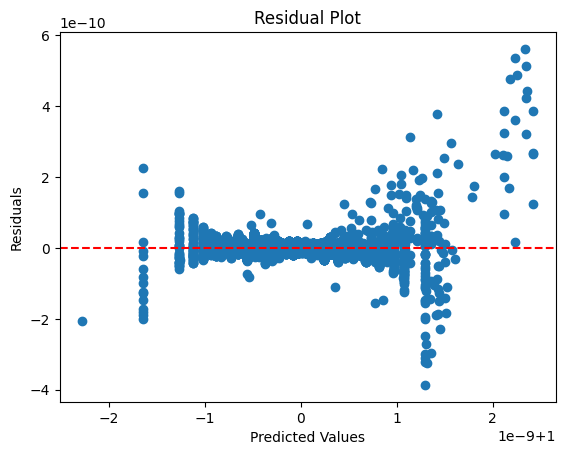

In [ ]:
import lightgbm as lgb

model = lgb.LGBMRegressor()
model.fit(train_df_value_X, train_df_value_Y)

y_test_pred = model.predict(validation_df_value_X)

original_y_test_pred = inv_boxcox(y_test_pred, fitted_lambda_tilt_erupt)
original_df_value_Y = inv_boxcox(validation_df_value_Y, fitted_lambda_tilt_erupt)

# Evaluate the model
mse = mean_squared_error(original_df_value_Y, original_y_test_pred)
print(f"Mean Squared Error: {mse}")


residuals = original_y_test_pred - original_df_value_Y
plt.scatter(original_y_test_pred, residuals)

plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

plt.axhline(y=0, color='r', linestyle='--')

plt.show()

LGBMRegressor (test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.097210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26562
[LightGBM] [Info] Number of data points in the train set: 218635, number of used features: 107
[LightGBM] [Info] Start training from score -0.000000
Mean Squared Error: 7.524733300150976e-19


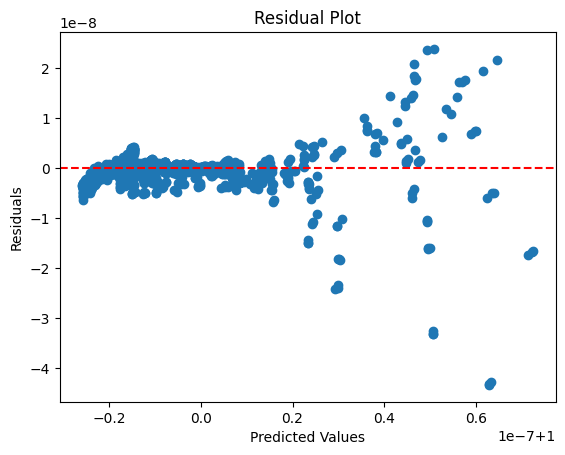

In [ ]:
import lightgbm as lgb

model = lgb.LGBMRegressor()
model.fit(train_df_value_X, train_df_value_Y)

y_test_pred = model.predict(test_df_value_X)

original_y_test_pred = inv_boxcox(y_test_pred, fitted_lambda_tilt_erupt)
original_df_value_Y = inv_boxcox(test_df_value_Y, fitted_lambda_tilt_erupt)

# Evaluate the model
mse = mean_squared_error(original_df_value_Y, original_y_test_pred)
print(f"Mean Squared Error: {mse}")


residuals = original_y_test_pred - original_df_value_Y
plt.scatter(original_y_test_pred, residuals)

plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

plt.axhline(y=0, color='r', linestyle='--')

plt.show()

The residual plot has improved at higher values but still fans out both for the validation and test datasets.

------

OrthogonalMatchingPursuitCV (validation)

OrthogonalMatchingPursuitCV coeff  1
Mean Squared Error: 5.400762531012457e-19


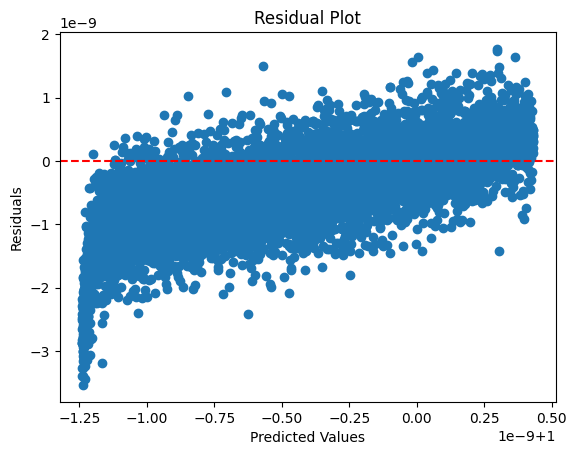

In [ ]:
from sklearn.linear_model import OrthogonalMatchingPursuitCV


model = OrthogonalMatchingPursuitCV(cv=5, max_iter=10)
model.fit(train_df_value_X, train_df_value_Y)

y_test_pred = model.predict(validation_df_value_X)

# The number of non-zero coefficients used by the model
n_nonzero_coefs = model.n_nonzero_coefs_

print(f"OrthogonalMatchingPursuitCV coeff  {n_nonzero_coefs}")

original_y_test_pred = inv_boxcox(y_test_pred, fitted_lambda_tilt_erupt)
original_df_value_Y = inv_boxcox(validation_df_value_Y, fitted_lambda_tilt_erupt)

# Evaluate the model
mse = mean_squared_error(original_df_value_Y, original_y_test_pred)
print(f"Mean Squared Error: {mse}")

residuals = original_y_test_pred - original_df_value_Y
plt.scatter(original_y_test_pred, residuals)

plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

plt.axhline(y=0, color='r', linestyle='--')

plt.show()

OrthogonalMatchingPursuitCV (test)

OrthogonalMatchingPursuitCV coeff  1
Mean Squared Error: 1.3456343766829812e-17


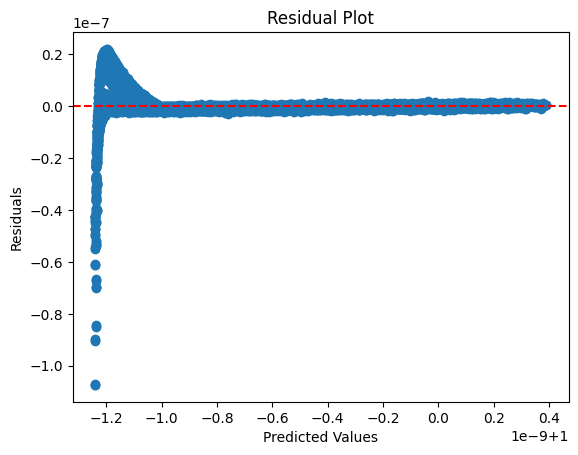

In [ ]:
from sklearn.linear_model import OrthogonalMatchingPursuitCV


model = OrthogonalMatchingPursuitCV(cv=5, max_iter=10)
model.fit(train_df_value_X, train_df_value_Y)

y_test_pred = model.predict(test_df_value_X)

# The number of non-zero coefficients used by the model
n_nonzero_coefs = model.n_nonzero_coefs_

print(f"OrthogonalMatchingPursuitCV coeff  {n_nonzero_coefs}")

original_y_test_pred = inv_boxcox(y_test_pred, fitted_lambda_tilt_erupt)
original_test_df_value_Y = inv_boxcox(test_df_value_Y, fitted_lambda_tilt_erupt)

# Evaluate the model
mse = mean_squared_error(original_test_df_value_Y, original_y_test_pred)
print(f"Mean Squared Error: {mse}")

residuals = original_y_test_pred - original_test_df_value_Y
plt.scatter(original_y_test_pred, residuals)

plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

plt.axhline(y=0, color='r', linestyle='--')

plt.show()


Here we can see that both validation and test datsets have some spread for lower predicted values but do well for rest of the spectrum



---



HistGradientBoostingRegressor (validation)

Mean Squared Error: 5.868119072459416e-20


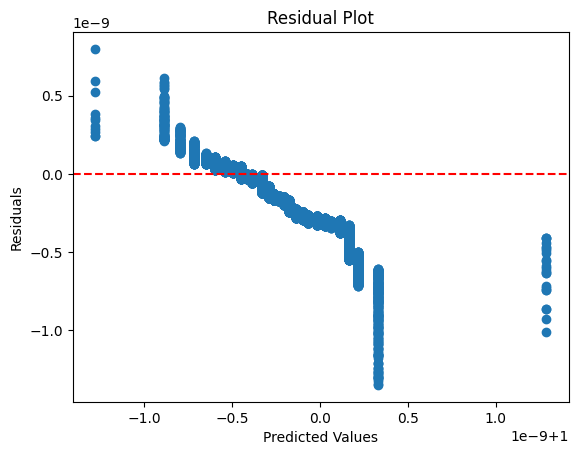

In [ ]:
from sklearn.ensemble import HistGradientBoostingRegressor

model = HistGradientBoostingRegressor(random_state=42)
model.fit(train_df_value_X, train_df_value_Y)

y_test_pred = model.predict(validation_df_value_X)

original_y_test_pred = inv_boxcox(y_test_pred, fitted_lambda_tilt_erupt)
original_df_value_Y = inv_boxcox(validation_df_value_Y, fitted_lambda_tilt_erupt)

# Evaluate the model
mse = mean_squared_error(original_df_value_Y, original_y_test_pred)
print(f"Mean Squared Error: {mse}")


residuals = original_y_test_pred - original_df_value_Y
plt.scatter(original_y_test_pred, residuals)

plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

plt.axhline(y=0, color='r', linestyle='--')

plt.show()

HistGradientBoostingRegressor (test)

Mean Squared Error: 2.237369239479168e-18


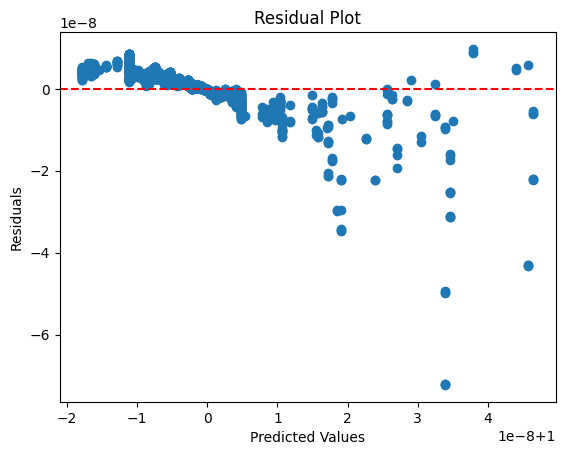

In [ ]:
from sklearn.ensemble import HistGradientBoostingRegressor

model = HistGradientBoostingRegressor(random_state=42)
model.fit(train_df_value_X, train_df_value_Y)

y_test_pred = model.predict(test_df_value_X)

original_y_test_pred = inv_boxcox(y_test_pred, fitted_lambda_tilt_erupt)
original_test_df_value_Y = inv_boxcox(test_df_value_Y, fitted_lambda_tilt_erupt)

# Evaluate the model
mse = mean_squared_error(original_test_df_value_Y, original_y_test_pred)
print(f"Mean Squared Error: {mse}")


residuals = original_y_test_pred - original_test_df_value_Y
plt.scatter(original_y_test_pred, residuals)

plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

plt.axhline(y=0, color='r', linestyle='--')

plt.show()

For HistGradientBoostingRegressor the validation dataset although spread has its values close to the 0 line but for the test datset we see some fanning out


---



After running the above algorithms i am going to fine tune LGBMRegressor and OrthogonalMatchingPursuitCV since they are both are potentially good models. We might need to fine tune LGBMRegressor to see if we can improve its residual plot.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from lightgbm import LGBMRegressor

# Define the parameter distributions
param_distributions = {
    'num_leaves': randint(20, 60),
    'max_depth': randint(5, 15),
    'learning_rate': uniform(0.01, 0.1),
    'n_estimators': randint(50, 300)
}

# Instantiate the model
lgbm = LGBMRegressor(random_state=42)

# Instantiate RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_distributions,
    n_iter=100,  # Number of parameter settings that are sampled
    cv=5,        # Number of folds in cross-validation
    random_state=42,
    scoring='neg_mean_squared_error'
)

# Fit RandomizedSearchCV to the data
random_search.fit(train_df_value_X, train_df_value_Y)

# Print the best parameters and the best score
print(f"Best parameters: {random_search.best_params_}")
print(f"Best score: {-random_search.best_score_}")

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [ ]:
best_params = {'learning_rate': 0.06720041992091831, 'max_depth': 5, 'n_estimators': 66, 'num_leaves': 47}

model = LGBMRegressor(**best_params)

model.fit(train_df_value_X, train_df_value_Y)

y_test_pred = model.predict(test_df_value_X)

original_y_test_pred = inv_boxcox(y_test_pred, fitted_lambda_tilt_erupt)
original_test_df_value_Y = inv_boxcox(test_df_value_Y, fitted_lambda_tilt_erupt)

# Evaluate the model
mse = mean_squared_error(original_test_df_value_Y, original_y_test_pred)
print(f"Mean Squared Error: {mse}")

[LightGBM] [Warning] num_iterations is set=200, max_iter=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26562
[LightGBM] [Info] Number of data points in the train set: 218635, number of used features: 107
[LightGBM] [Info] Start training from score -0.000000
Mean Squared Error: 1.1153768258842555e-18


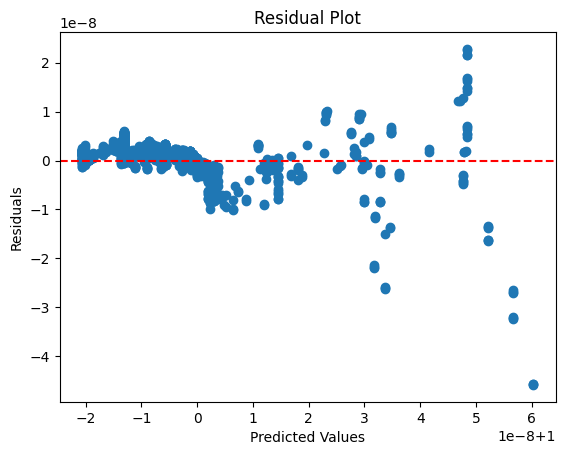

In [ ]:

original_y_test_pred = inv_boxcox(y_test_pred, fitted_lambda_tilt_erupt)
original_test_df_value_Y = inv_boxcox(test_df_value_Y, fitted_lambda_tilt_erupt)

residuals = original_y_test_pred - original_test_df_value_Y
plt.scatter(original_y_test_pred, residuals)

plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

plt.axhline(y=0, color='r', linestyle='--')

plt.show()

There is still fanning out at higher predicted values but the error has improved compared to the default hyperparametes we used before.




### Conclusion for tilt erupt prediction

From our analysis the OrthogonalMatchingPursuitCV algorithm works best for estimation followed by the LGBMRegressor

----------------

### Time to erupt prediction

In [ ]:
# LazyRegressor for time to erupt value
highmem_regressors = [
    "GammaRegressor", "GaussianProcessRegressor", "KernelRidge", "QuantileRegressor", "NuSVR"
]
regressors = [reg for reg in lazypredict.Supervised.REGRESSORS if reg[0] not in highmem_regressors]

REGRESSOR_Q1 = regressors[:10]
REGRESSOR_Q2 = regressors[10:20]
REGRESSOR_Q3 = regressors[20:30]
REGRESSOR_Q4 = regressors[30:]



In [ ]:
regressors = REGRESSOR_Q1

reg = LazyRegressor(regressors=regressors, verbose=1, ignore_warnings=True, custom_metric=None)
models, predictions = reg.fit(train_df_time_X, validation_df_time_X, train_df_time_Y, validation_df_time_Y)

print(models)

'tuple' object has no attribute '__name__'
Invalid Regressor(s)


 10%|█         | 1/10 [03:56<35:32, 236.92s/it]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.0028154408117574414, 'Adjusted R-Squared': -0.003947489265769599, 'RMSE': 394.0639654564121, 'Time taken': 236.91964435577393}


 20%|██        | 2/10 [11:30<48:32, 364.12s/it]

{'Model': 'BaggingRegressor', 'R-Squared': 0.009606188502762403, 'Adjusted R-Squared': 0.002889313442218211, 'RMSE': 392.7199011427115, 'Time taken': 453.1486248970032}


 30%|███       | 3/10 [11:33<23:16, 199.46s/it]

{'Model': 'BayesianRidge', 'R-Squared': -0.008538639567778006, 'Adjusted R-Squared': -0.015378573296227938, 'RMSE': 396.3010487686996, 'Time taken': 3.508500814437866}


 40%|████      | 4/10 [12:38<14:38, 146.48s/it]

{'Model': 'DecisionTreeRegressor', 'R-Squared': -0.44904254061794924, 'Adjusted R-Squared': -0.45886998258068745, 'RMSE': 475.0283381703044, 'Time taken': 65.25793385505676}


 50%|█████     | 5/10 [12:39<07:50, 94.04s/it] 

{'Model': 'DummyRegressor', 'R-Squared': -0.015601982778008283, 'Adjusted R-Squared': -0.022489820272921568, 'RMSE': 397.6863830548924, 'Time taken': 1.0716040134429932}


 60%|██████    | 6/10 [12:45<04:15, 63.93s/it]

{'Model': 'ElasticNet', 'R-Squared': -0.005498245805721336, 'Adjusted R-Squared': -0.012317559509290588, 'RMSE': 395.70324286524414, 'Time taken': 5.477859735488892}


 70%|███████   | 7/10 [12:53<02:17, 45.72s/it]

{'Model': 'ElasticNetCV', 'R-Squared': -0.008752698927587454, 'Adjusted R-Squared': -0.015594084411852727, 'RMSE': 396.34310340330063, 'Time taken': 8.208093166351318}


 80%|████████  | 8/10 [13:02<01:07, 33.96s/it]

{'Model': 'ExtraTreeRegressor', 'R-Squared': -1.1407279557636234, 'Adjusted R-Squared': -1.1552464251346515, 'RMSE': 577.377281081309, 'Time taken': 8.778398275375366}


 90%|█████████ | 9/10 [24:25<03:56, 236.74s/it]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.08984581388137436, 'Adjusted R-Squared': 0.08367312592329024, 'RMSE': 376.47525508741194, 'Time taken': 682.6143202781677}


		100%|██████████| 10/10 [44:56<00:00, 269.62s/it]
		{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.0562713528122345, 'Adjusted R-Squared': 0.04987096203774688, 'RMSE': 383.35622516171173, 'Time taken': 1231.1497061252594}
		                           Adjusted R-Squared  R-Squared   RMSE  Time Taken
		Model                                                                      
		ExtraTreesRegressor                      0.08       0.09 376.48      682.61
		GradientBoostingRegressor                0.05       0.06 383.36     1231.15
		BaggingRegressor                         0.00       0.01 392.72      453.15
		AdaBoostRegressor                       -0.00       0.00 394.06      236.92
		ElasticNet                              -0.01      -0.01 395.70        5.48
		BayesianRidge                           -0.02      -0.01 396.30        3.51
		ElasticNetCV                            -0.02      -0.01 396.34        8.21
		DummyRegressor                          -0.02      -0.02 397.69        1.07
		DecisionTreeRegressor                   -0.46      -0.45 475.03       65.26
		ExtraTreeRegressor                      -1.16      -1.14 577.38        8.78

In [ ]:
regressors = REGRESSOR_Q2

reg = LazyRegressor(regressors=regressors, verbose=1, ignore_warnings=True, custom_metric=None)
models, predictions = reg.fit(train_df_time_X, validation_df_time_X, train_df_time_Y, validation_df_time_Y)

print(models)

'tuple' object has no attribute '__name__'
Invalid Regressor(s)


 10%|█         | 1/10 [00:44<06:40, 44.54s/it]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.14506521791357763, 'Adjusted R-Squared': 0.11109615247360516, 'RMSE': 364.87612236545885, 'Time taken': 44.53755569458008}


 20%|██        | 2/10 [02:22<10:05, 75.71s/it]

{'Model': 'HuberRegressor', 'R-Squared': 0.0031498492553756474, 'Adjusted R-Squared': -0.03645792985714569, 'RMSE': 393.99788472638903, 'Time taken': 97.52387428283691}


 30%|███       | 3/10 [03:05<07:06, 60.92s/it]

{'Model': 'KNeighborsRegressor', 'R-Squared': -0.5027436798821394, 'Adjusted R-Squared': -0.5624520921154614, 'RMSE': 483.75047652996176, 'Time taken': 43.32752442359924}


 40%|████      | 4/10 [03:12<03:58, 39.70s/it]

{'Model': 'Lars', 'R-Squared': -24655972.667349212, 'Adjusted R-Squared': -25635626.78897525, 'RMSE': 1959476.3655411596, 'Time taken': 7.15263557434082}


 50%|█████     | 5/10 [03:41<02:58, 35.65s/it]

{'Model': 'LarsCV', 'R-Squared': -0.035816660368165776, 'Adjusted R-Squared': -0.07697269315231692, 'RMSE': 401.62468395292166, 'Time taken': 28.470943450927734}


 60%|██████    | 6/10 [04:12<02:17, 34.36s/it]

{'Model': 'Lasso', 'R-Squared': 0.0014780092521038402, 'Adjusted R-Squared': -0.038196196965345486, 'RMSE': 394.3281377112406, 'Time taken': 31.852319955825806}


 70%|███████   | 7/10 [05:01<01:57, 39.16s/it]

{'Model': 'LassoCV', 'R-Squared': -0.010350734725803612, 'Adjusted R-Squared': -0.05049493162169716, 'RMSE': 396.656916603082, 'Time taken': 49.03645706176758}


 80%|████████  | 8/10 [05:08<00:57, 28.87s/it]

{'Model': 'LassoLars', 'R-Squared': 0.0014518741311025929, 'Adjusted R-Squared': -0.038223370511328625, 'RMSE': 394.3332982115871, 'Time taken': 6.839645862579346}


 90%|█████████ | 9/10 [05:28<00:26, 26.10s/it]

{'Model': 'LassoLarsCV', 'R-Squared': -0.010504603225195641, 'Adjusted R-Squared': -0.0506549137676906, 'RMSE': 396.68711932323566, 'Time taken': 20.00794792175293}


100%|██████████| 10/10 [05:47<00:00, 34.75s/it]

{'Model': 'LassoLarsIC', 'R-Squared': 0.001971427435566553, 'Adjusted R-Squared': -0.03768317383082165, 'RMSE': 394.2306973355664, 'Time taken': 18.753080129623413}
                               Adjusted R-Squared    R-Squared       RMSE  \
Model                                                                       
HistGradientBoostingRegressor                0.11         0.15     364.88   
HuberRegressor                              -0.04         0.00     394.00   
LassoLarsIC                                 -0.04         0.00     394.23   
Lasso                                       -0.04         0.00     394.33   
LassoLars                                   -0.04         0.00     394.33   
LassoCV                                     -0.05        -0.01     396.66   
LassoLarsCV                                 -0.05        -0.01     396.69   
LarsCV                                      -0.08        -0.04     401.62   
KNeighborsRegressor                         -0.56        -0.50   

In [ ]:
regressors = REGRESSOR_Q3

reg = LazyRegressor(regressors=regressors, verbose=1, ignore_warnings=True, custom_metric=None)
models, predictions = reg.fit(train_df_time_X, validation_df_time_X, train_df_time_Y, validation_df_time_Y)

print(models)

'tuple' object has no attribute '__name__'
Invalid Regressor(s)


 10%|█         | 1/10 [00:03<00:32,  3.58s/it]

{'Model': 'LinearRegression', 'R-Squared': -0.00886220670387261, 'Adjusted R-Squared': -0.015704334872555847, 'RMSE': 396.36461584836655, 'Time taken': 3.5740468502044678}


 20%|██        | 2/10 [01:05<05:04, 38.07s/it]

{'Model': 'LinearSVR', 'R-Squared': -0.010762138185897996, 'Adjusted R-Squared': -0.017617151736376124, 'RMSE': 396.7376655023775, 'Time taken': 62.21704173088074}


 30%|███       | 3/10 [07:50<23:59, 205.58s/it]

{'Model': 'MLPRegressor', 'R-Squared': 0.014171218762104587, 'Adjusted R-Squared': 0.00748530384846724, 'RMSE': 391.813772260937, 'Time taken': 404.9169201850891}


 40%|████      | 4/10 [07:52<12:29, 124.94s/it]

{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': -0.007412389691209942, 'Adjusted R-Squared': -0.014244685165442084, 'RMSE': 396.0797093641895, 'Time taken': 1.3114309310913086}


 50%|█████     | 5/10 [07:56<06:47, 81.55s/it] 

{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': -0.00883762963334278, 'Adjusted R-Squared': -0.015679591119732272, 'RMSE': 396.3597878647313, 'Time taken': 4.614251136779785}


 60%|██████    | 6/10 [08:00<03:40, 55.22s/it]

{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.0940780251914124, 'Adjusted R-Squared': -0.1014980891259678, 'RMSE': 412.76522218739126, 'Time taken': 4.086780071258545}


 70%|███████   | 7/10 [08:08<01:59, 39.70s/it]

{'Model': 'PoissonRegressor', 'R-Squared': -0.00304814863130054, 'Adjusted R-Squared': -0.00985084571588879, 'RMSE': 395.2208438536267, 'Time taken': 7.7579615116119385}


 80%|████████  | 8/10 [08:16<00:59, 29.59s/it]

{'Model': 'RANSACRegressor', 'R-Squared': -4.027997303885001e+17, 'Adjusted R-Squared': -4.05531528014891e+17, 'RMSE': 250451441910.0852, 'Time taken': 7.929083585739136}


		90%|█████████ | 9/10 [1:22:08<23:25, 1405.75s/it]
		{'Model': 'RandomForestRegressor', 'R-Squared': 0.07381639197072642, 'Adjusted R-Squared': 0.0675349920810685, 'RMSE': 379.77598252488065, 'Time taken': 4431.669256687164}
		100%|██████████| 10/10 [1:22:09<00:00, 492.96s/it]
		{'Model': 'Ridge', 'R-Squared': -0.008853564168589845, 'Adjusted R-Squared': -0.015695633723387337, 'RMSE': 396.3629180929689, 'Time taken': 1.4940581321716309}
		                                Adjusted R-Squared              R-Squared  \
		Model                                                                       
		RandomForestRegressor                         0.07                   0.07   
		MLPRegressor                                  0.01                   0.01   
		PoissonRegressor                             -0.01                  -0.00   
		OrthogonalMatchingPursuit                    -0.01                  -0.01   
		OrthogonalMatchingPursuitCV                  -0.02                  -0.01   
		Ridge                                        -0.02                  -0.01   
		LinearRegression                             -0.02                  -0.01   
		LinearSVR                                    -0.02                  -0.01   
		PassiveAggressiveRegressor                   -0.10                  -0.09   
		RANSACRegressor             -405531528014891008.00 -402799730388500096.00   

		                                       RMSE  Time Taken  
		Model                                                    
		RandomForestRegressor                379.78     4431.67  
		MLPRegressor                         391.81      404.92  
		PoissonRegressor                     395.22        7.76  
		OrthogonalMatchingPursuit            396.08        1.31  
		OrthogonalMatchingPursuitCV          396.36        4.61  
		Ridge                                396.36        1.49  
		LinearRegression                     396.36        3.57  
		LinearSVR                            396.74       62.22  
		PassiveAggressiveRegressor           412.77        4.09  
		RANSACRegressor             250451441910.09        7.93

In [ ]:
regressors = REGRESSOR_Q4

reg = LazyRegressor(regressors=regressors, verbose=1, ignore_warnings=True, custom_metric=None)
models, predictions = reg.fit(train_df_time_X, validation_df_time_X, train_df_time_Y, validation_df_time_Y)

print(models)

'tuple' object has no attribute '__name__'
Invalid Regressor(s)


 14%|█▍        | 1/7 [00:07<00:43,  7.27s/it]

{'Model': 'RidgeCV', 'R-Squared': -0.00874835213996672, 'Adjusted R-Squared': -0.015589708144212011, 'RMSE': 0.24510961624426256, 'Time taken': 7.2692201137542725}


 29%|██▊       | 2/7 [00:13<00:32,  6.55s/it]

{'Model': 'SGDRegressor', 'R-Squared': -1.0237262106820082e+22, 'Adjusted R-Squared': -1.0306691468893337e+22, 'RMSE': 24692260055.719032, 'Time taken': 6.036644220352173}


We will try a few ensemble techniques to predict eruption time since those algorithms seems to do better with this dataset



---



HistGradientBoostingRegressor

Let's try some hyper parameter tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define a grid of hyperparameters to search over
param_grid = {
    'max_iter': [200, 300, 500],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.001],
}

# Initialize the grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')


# Fit the grid search to the data
grid_search.fit(train_df_time_X, train_df_time_Y)

# Get the best parameters and the corresponding best score
best_params = grid_search.best_params_
best_score = -grid_search.best_score_
print(f"Best Mean Squared Error: {best_score}")
print(f"Best Parameters: {best_params}")

Best Mean Squared Error: 130249.70135480257
Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'max_iter': 200}


Root Mean Squared Error: 670.571848569991
R-squared: -3.562873898034209e+24


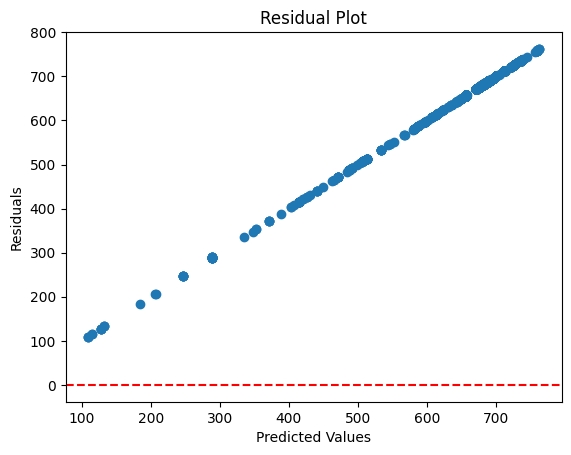

In [ ]:
from sklearn.ensemble import HistGradientBoostingRegressor

best_params = {'learning_rate': 0.01, 'max_depth': 3, 'max_iter': 200}

# Initialize the regressor with the best parameters
best_regressor = HistGradientBoostingRegressor(**best_params)
best_regressor.fit(train_df_time_X, train_df_time_Y)

y_test_pred = best_regressor.predict(validation_df_time_X)

# Evaluate the model's performance
rmse = mean_squared_error(validation_df_value_Y, y_test_pred, squared=False)
r2 = r2_score(validation_df_value_Y, y_test_pred)

print(f"Root Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

residuals = y_test_pred - validation_df_value_Y
plt.scatter(y_test_pred, residuals)

plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

plt.axhline(y=0, color='r', linestyle='--')

plt.show()


Fine-tuned Root Mean Squared Error: 341.7998736160196
Fine-tuned R-squared: 0.16785767756566805


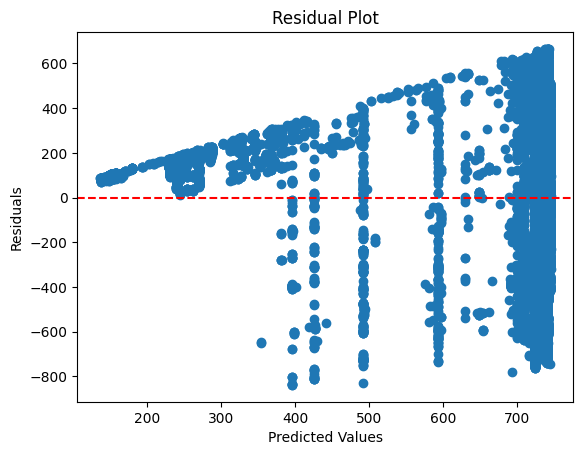

In [ ]:
best_params = {'learning_rate': 0.01, 'max_depth': 3, 'max_iter': 200}

# Initialize the regressor with the best parameters
best_regressor = HistGradientBoostingRegressor(**best_params, random_state=42)

# Fit the model on the training data
best_regressor.fit(train_df_time_X, train_df_time_Y)

# Predict on the test set
y_pred_best = best_regressor.predict(test_df_time_X)


# Evaluate the model's performance
rmse_best = mean_squared_error(test_df_time_Y, y_pred_best, squared=False)
r2_best = r2_score(test_df_time_Y, y_pred_best)
print(f"Fine-tuned Root Mean Squared Error: {rmse_best}")
print(f"Fine-tuned R-squared: {r2_best}")


residuals = y_pred_best - test_df_time_Y
plt.scatter(y_pred_best, residuals)

plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

plt.axhline(y=0, color='r', linestyle='--')

plt.show()

The residual plot for validation dataset with HistGradientBoostingRegressor is linear. Unlike the plot for the test dataset. But the test dataset residual plot also fans out at larger values of prediction.

Trying BaggingRegressor and GradientBoostingRegressor which are non-linear and have a better RMSE as per the lazy predict run.

BaggingRegressor

Mean Squared Error: 408.1268091322921


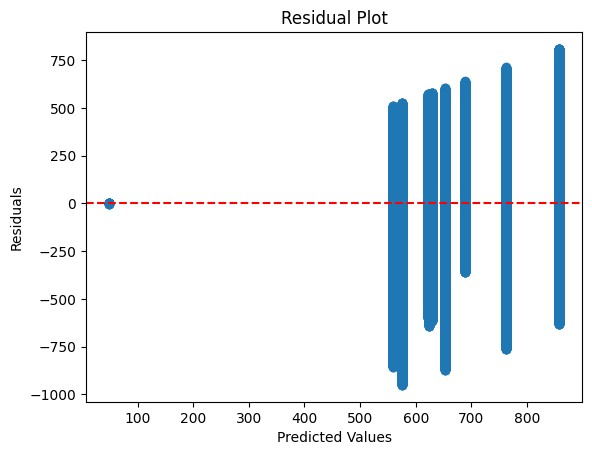

In [ ]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

# Choose a base estimator, for example, a decision tree regressor
base_estimator = DecisionTreeRegressor()

# Instantiate the BaggingRegressor with 100 base estimators
bagging_regressor = BaggingRegressor(base_estimator=base_estimator, n_estimators=100)

# Fit the model
bagging_regressor.fit(train_df_time_X, train_df_time_Y)

# Predict on new data
predictions = bagging_regressor.predict(validation_df_time_X)


# Evaluate the model's performance
rmse = mean_squared_error(validation_df_time_Y, predictions, squared=False)
r2 = r2_score(validation_df_time_Y, predictions)

print(f"Mean Squared Error: {rmse}")

residuals = predictions - validation_df_time_Y
plt.scatter(predictions, residuals)

plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

plt.axhline(y=0, color='r', linestyle='--')

plt.show()


Mean Squared Error: 378.2725481676794


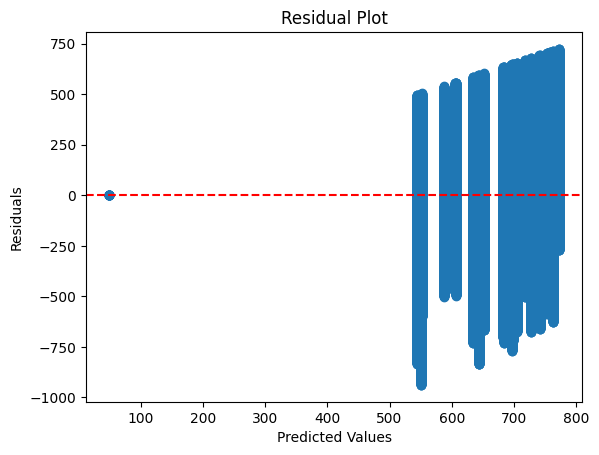

In [ ]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

# Choose a base estimator, for example, a decision tree regressor
base_estimator = DecisionTreeRegressor()

# Instantiate the BaggingRegressor with 100 base estimators
bagging_regressor = BaggingRegressor(base_estimator=base_estimator, n_estimators=100)

# Fit the model
bagging_regressor.fit(train_df_time_X, train_df_time_Y)

# Predict on new data
predictions = bagging_regressor.predict(test_df_time_X)

# Evaluate the model's performance
rmse = mean_squared_error(test_df_time_Y, predictions, squared=False)
r2 = r2_score(test_df_time_Y, predictions)

print(f"Mean Squared Error: {rmse}")
print(f"R-squared Error: {rmse}")

residuals = predictions - test_df_time_Y
plt.scatter(predictions, residuals)

plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

plt.axhline(y=0, color='r', linestyle='--')

plt.show()

Going to try eXtreme Gradient Boosting to see if we can improve on the results we are seeing.

XGBRegressor

Fine-tuned Root Mean Squared Error: 377.25948485329286
Fine-tuned R-squared: 0.08605000836027443


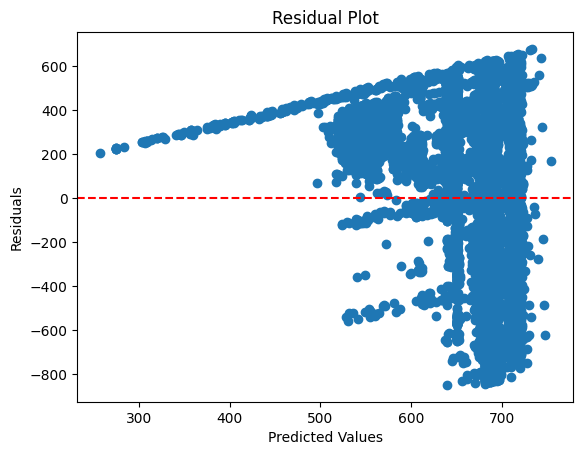

In [ ]:
# Initialize the regressor with the best parameters
best_regressor = XGBRegressor(**best_params)

# Fit the model on the training data
best_regressor.fit(train_df_time_X, train_df_time_Y)

# Predict on the test set
y_pred_best = best_regressor.predict(validation_df_time_X)


# Evaluate the model's performance
rmse_best = mean_squared_error(validation_df_time_Y, y_pred_best, squared=False)
r2_best = r2_score(validation_df_time_Y, y_pred_best)
print(f"Fine-tuned Root Mean Squared Error: {rmse_best}")
print(f"Fine-tuned R-squared: {r2_best}")


residuals = y_pred_best - validation_df_time_Y
plt.scatter(y_pred_best, residuals)

plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

plt.axhline(y=0, color='r', linestyle='--')

plt.show()

Fine-tuned Root Mean Squared Error: 353.79468792470124
Fine-tuned R-squared: 0.10842797975980423


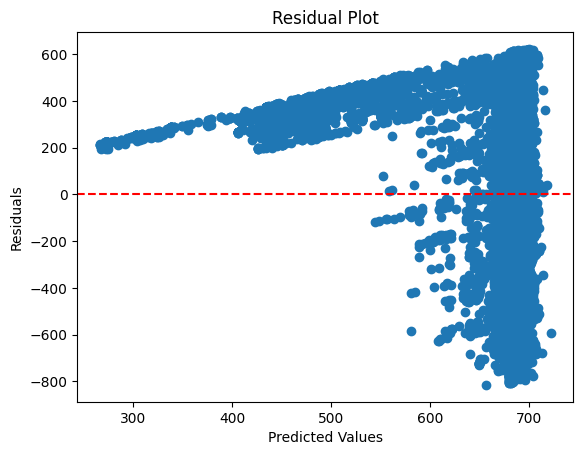

In [ ]:
# Initialize the regressor with the best parameters
best_regressor = XGBRegressor(**best_params)

# Fit the model on the training data
best_regressor.fit(train_df_time_X, train_df_time_Y)

# Predict on the test set
y_pred_best = best_regressor.predict(test_df_time_X)


# Evaluate the model's performance
rmse_best = mean_squared_error(test_df_time_Y, y_pred_best, squared=False)
r2_best = r2_score(test_df_time_Y, y_pred_best)
print(f"Fine-tuned Root Mean Squared Error: {rmse_best}")
print(f"Fine-tuned R-squared: {r2_best}")


residuals = y_pred_best - test_df_time_Y
plt.scatter(y_pred_best, residuals)

plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

plt.axhline(y=0, color='r', linestyle='--')

plt.show()

Conclusion for Time of eruption prediction


Even with further optimisation of non-linear algorithms all models result in fanning off of predicted time of eruption during the residual plots. So errors in prediction couldn't be reduced.



---



Furture enhancements to improve results

1) Frequency Analysis (e.g., Fast Fourier Transform, FFT): Convert sensor signals from the time domain to the frequency domain, unveiling hidden patterns and periodicities related to underlying systems.

2) Noise Filtering: Use noise reduction techniques like smoothing filters (moving average, Kalman filters) to improve signal-to-noise ratio. This makes it easier to extract relevant patterns.

3) ARIMA/SARIMA: Classic time series models that explicitly model autocorrelation (how past values influence the present). ARIMA works with stationary data, while SARIMA adds components for seasonality and trends.

4) Using neural networks like LSTM and Transformers for deeper emphasis of underlying patterns in the dataset.

